In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#Using the dataset specified in the Dataset section at page 6, conduct an EDA and create an
#interactive notebook (.ipynb file) in Python that can be used as a presentation to explain the
#findings of your analysis. It should contain appropriate visualizations and explanations to assist
#readers in understanding how these elaborations are arrived at and their implications.


## Dataset cleaning


In [2]:
import sqlite3

conn = sqlite3.connect("data/gas_monitoring.db")
# Read sqlite query results into a pandas DataFrame
df = pd.read_sql_query("SELECT * from gas_monitoring", conn)

# Verify that result of SQL query is stored in the dataframe
print(df.head())
print(df.shape)
conn.close()


  Time of Day  Temperature  Humidity  CO2_InfraredSensor  \
0     morning        19.63     53.83          125.486389   
1     morning       292.81     53.69          126.343018   
2     morning        19.62     54.25          126.560695   
3     morning        20.10     50.48          113.504877   
4     morning        19.89     48.42           92.766225   

   CO2_ElectroChemicalSensor  MetalOxideSensor_Unit1  MetalOxideSensor_Unit2  \
0                 571.089440              478.554958              735.850412   
1                 575.789501              491.955151              740.282738   
2                 585.543111              505.560808              737.112906   
3                 597.449961              515.142272              744.020651   
4                 613.654875              535.664558              770.265441   

   MetalOxideSensor_Unit3  MetalOxideSensor_Unit4  CO_GasSensor  Session ID  \
0              654.625253              565.051969           2.0        7241   


In [3]:
print(df.shape) #check size
print(df.dtypes) #check datatypes
print(df[df.duplicated()] ) #check duplicate

(10000, 14)
Time of Day                   object
Temperature                  float64
Humidity                     float64
CO2_InfraredSensor           float64
CO2_ElectroChemicalSensor    float64
MetalOxideSensor_Unit1       float64
MetalOxideSensor_Unit2       float64
MetalOxideSensor_Unit3       float64
MetalOxideSensor_Unit4       float64
CO_GasSensor                 float64
Session ID                     int64
HVAC Operation Mode           object
Ambient Light Level           object
Activity Level                object
dtype: object
     Time of Day  Temperature  Humidity  CO2_InfraredSensor  \
493      evening        23.52     43.25           88.690954   
1097     morning        18.99     55.92          118.637160   
1252     evening        24.06     44.04          105.264563   
1491     morning        17.37     44.26           60.765226   
1576       night        20.77       NaN          105.027749   
...          ...          ...       ...                 ...   
9784     mornin

In [4]:
#remove duplicates
df = df.drop_duplicates()
print(df.head())
print(df[df.duplicated()]) #check that duplicates are removed
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

  Time of Day  Temperature  Humidity  CO2_InfraredSensor  \
0     morning        19.63     53.83          125.486389   
1     morning       292.81     53.69          126.343018   
2     morning        19.62     54.25          126.560695   
3     morning        20.10     50.48          113.504877   
4     morning        19.89     48.42           92.766225   

   CO2_ElectroChemicalSensor  MetalOxideSensor_Unit1  MetalOxideSensor_Unit2  \
0                 571.089440              478.554958              735.850412   
1                 575.789501              491.955151              740.282738   
2                 585.543111              505.560808              737.112906   
3                 597.449961              515.142272              744.020651   
4                 613.654875              535.664558              770.265441   

   MetalOxideSensor_Unit3  MetalOxideSensor_Unit4  CO_GasSensor  Session ID  \
0              654.625253              565.051969           2.0        7241   


In [5]:
df.isna().sum() 

Time of Day                     0
Temperature                     0
Humidity                     1917
CO2_InfraredSensor              0
CO2_ElectroChemicalSensor       0
MetalOxideSensor_Unit1          0
MetalOxideSensor_Unit2       1406
MetalOxideSensor_Unit3          0
MetalOxideSensor_Unit4          0
CO_GasSensor                  830
Session ID                      0
HVAC Operation Mode             0
Ambient Light Level          1052
Activity Level                  0
dtype: int64

In [6]:
valid_ranges = {
            "Temperature": (-40, 85), #Temperature in a resident home shouldnt be too high or too low
            "Humidity": (0, 100), #percentage so 0 to 100
            "CO2_InfraredSensor": (0, 5000), #Not sure Min Max value of a Sensor so set as 0 and 5000
            "CO2_ElectroChemicalSensor": (0, 5000), #Not sure Min Max value of a Sensor so set as 0 and 5000
            "MetalOxideSensor_Unit1": (0, None),
            "MetalOxideSensor_Unit2": (0, None),
            "MetalOxideSensor_Unit3": (0, None),
            "MetalOxideSensor_Unit4": (0, None),
            "CO_GasSensor": (0, None),
        }

for col, (low, high) in valid_ranges.items():
            if col not in df.columns:
                continue
            if low is not None:
                df.loc[df[col] < low, col] = np.nan
            if high is not None:
                df.loc[df[col] > high, col] = np.nan

In [7]:
#filling in the missing/not possible values for humidity 
print("Max:", df["Humidity"].max())
print("Min:", df["Humidity"].min())
# mark bad humidity values as missing
df.loc[(df["Humidity"] < 0) | (df["Humidity"] > 100), "Humidity"] = None
print("Max:", df["Humidity"].max())
print("Min:", df["Humidity"].min())
df["Humidity"].interpolate(method="linear", inplace=True)
print(df["Humidity"].mean())

Max: 59.73
Min: 39.69
Max: 59.73
Min: 39.69
50.874921660392715


In [8]:
#filling in the missing values for MetalOxideSensor_Unit2 
df["MetalOxideSensor_Unit2"].interpolate(method="linear", inplace=True)
df["CO_GasSensor"].interpolate(method="linear", inplace=True)

In [9]:
#one hot encode Ambient Light Level
df["Ambient Light Level"] = df['Ambient Light Level'].fillna(df['Ambient Light Level'].mode()[0])  
print(df["Ambient Light Level"].value_counts())

Ambient Light Level
very_bright    4369
bright         2655
moderate       1429
dim             852
very_dim        524
Name: count, dtype: int64


In [10]:
df.isna().sum() 

Time of Day                    0
Temperature                  795
Humidity                       0
CO2_InfraredSensor           113
CO2_ElectroChemicalSensor      0
MetalOxideSensor_Unit1         0
MetalOxideSensor_Unit2         0
MetalOxideSensor_Unit3         0
MetalOxideSensor_Unit4         0
CO_GasSensor                   0
Session ID                     0
HVAC Operation Mode            0
Ambient Light Level            0
Activity Level                 0
dtype: int64

In [11]:
#Check for Negative Sensors
for col in numeric_cols:

    print(f"Max {col}: {df[col].max()}" )
    print(f"Min {col}: { df[col].min()}")




Max Temperature: 34.30127066332731
Min Temperature: 6.903485286098476
Max Humidity: 59.73
Min Humidity: 39.69
Max CO2_InfraredSensor: 237.87393823719628
Min CO2_InfraredSensor: 0.0279669264758837
Max CO2_ElectroChemicalSensor: 637.8957901222333
Min CO2_ElectroChemicalSensor: 408.5993857456847
Max MetalOxideSensor_Unit1: 632.8916927682109
Min MetalOxideSensor_Unit1: 286.82566166676975
Max MetalOxideSensor_Unit2: 807.7329425794551
Min MetalOxideSensor_Unit2: 611.1689162204458
Max MetalOxideSensor_Unit3: 906.213097367836
Min MetalOxideSensor_Unit3: 456.67390029486296
Max MetalOxideSensor_Unit4: 736.1123607504734
Min MetalOxideSensor_Unit4: 412.7919042275865
Max CO_GasSensor: 4.0
Min CO_GasSensor: 0.0
Max Session ID: 9658
Min Session ID: 1374


In [12]:
#Replace Negative Sensor values to reduce skewness
for col in numeric_cols:
    df.loc[(df[col] < 0), col] = None
    df[col].interpolate(method="linear", inplace=True)
    print(f"Max {col}: {df[col].max()}" )
    print(f"Min {col}: { df[col].min()}")

Max Temperature: 34.30127066332731
Min Temperature: 6.903485286098476
Max Humidity: 59.73
Min Humidity: 39.69
Max CO2_InfraredSensor: 237.87393823719628
Min CO2_InfraredSensor: 0.0279669264758837
Max CO2_ElectroChemicalSensor: 637.8957901222333
Min CO2_ElectroChemicalSensor: 408.5993857456847
Max MetalOxideSensor_Unit1: 632.8916927682109
Min MetalOxideSensor_Unit1: 286.82566166676975
Max MetalOxideSensor_Unit2: 807.7329425794551
Min MetalOxideSensor_Unit2: 611.1689162204458
Max MetalOxideSensor_Unit3: 906.213097367836
Min MetalOxideSensor_Unit3: 456.67390029486296
Max MetalOxideSensor_Unit4: 736.1123607504734
Min MetalOxideSensor_Unit4: 412.7919042275865
Max CO_GasSensor: 4.0
Min CO_GasSensor: 0.0
Max Session ID: 9658.0
Min Session ID: 1374.0


## EDA

In [13]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(df,title = "gas monitoring")
# profile.to_file("gas_monitoring.html")

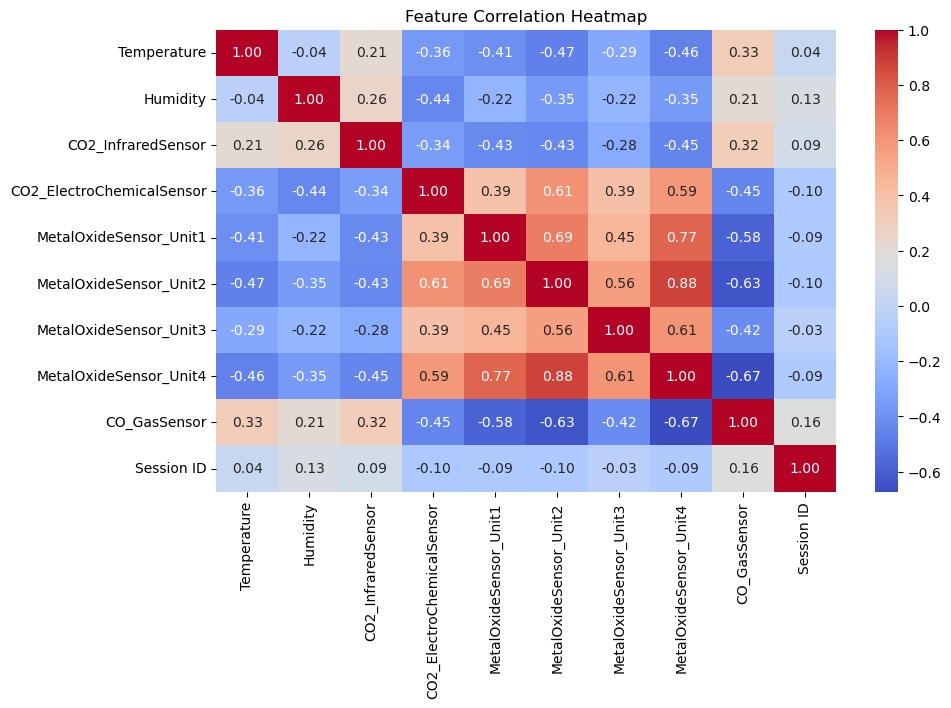

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlations (only numeric columns)
corr = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


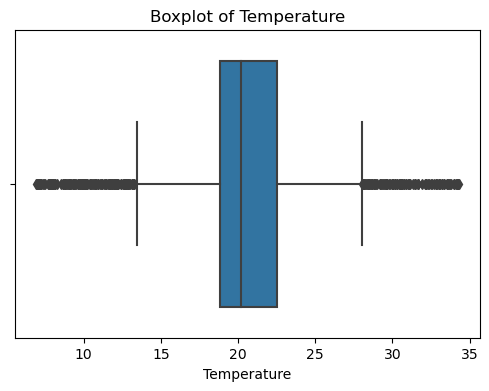

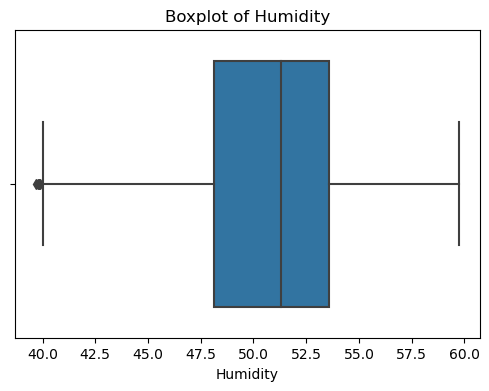

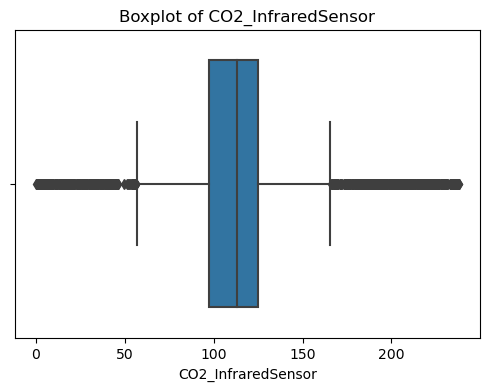

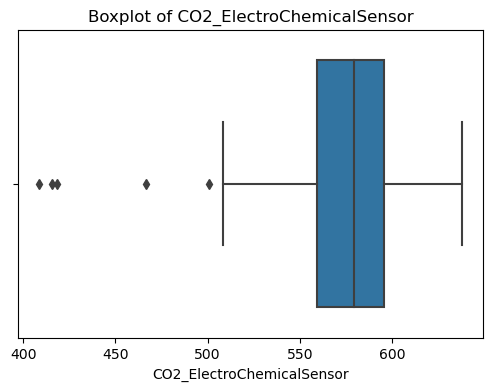

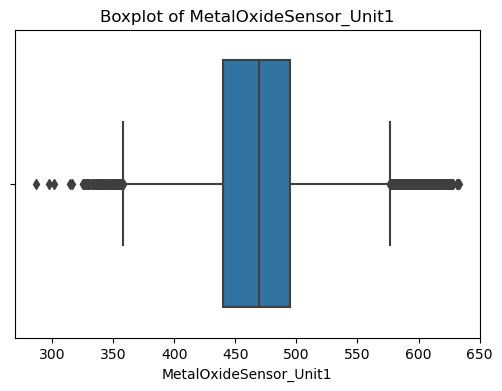

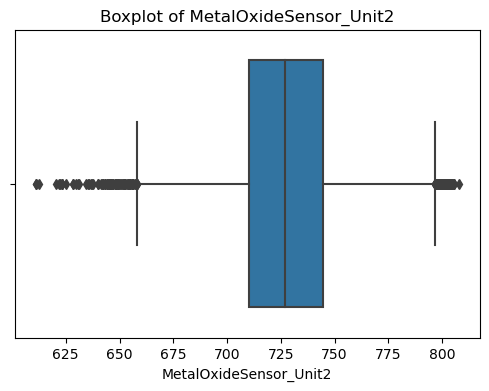

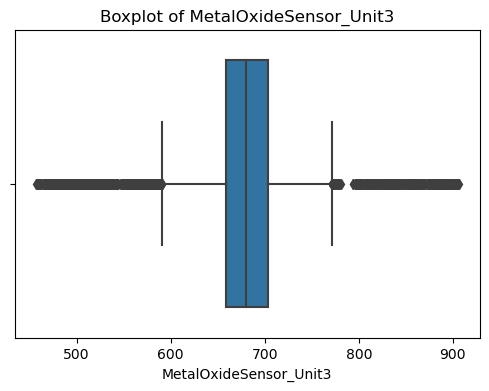

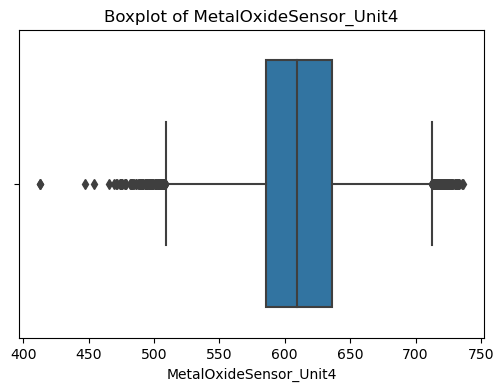

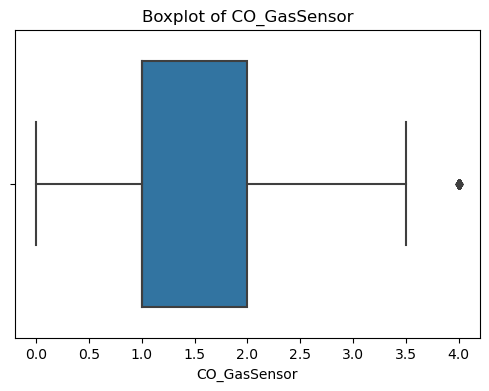

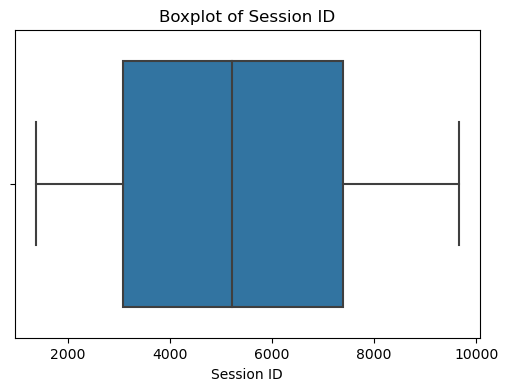

In [15]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [16]:
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Outlier mask
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outliers
#find all outliers    


outlier_dict = {}
for col in numeric_cols:
    outliers = detect_outliers_iqr(df, col)
    outlier_dict[col] = outliers.index.tolist()  # save row indices

# Print summary
for col, idx in outlier_dict.items():
    print(f"{col}: {len(idx)} outliers -> {idx[:10]}...")  # show first 10 indices


Temperature: 251 outliers -> [54, 80, 89, 111, 133, 137, 198, 252, 266, 356]...
Humidity: 5 outliers -> [1401, 1402, 1403, 3253, 4907]...
CO2_InfraredSensor: 712 outliers -> [9, 53, 81, 100, 112, 125, 178, 191, 207, 214]...
CO2_ElectroChemicalSensor: 5 outliers -> [3780, 7594, 9319, 9320, 9325]...
MetalOxideSensor_Unit1: 603 outliers -> [10, 15, 41, 100, 113, 286, 291, 318, 393, 394]...
MetalOxideSensor_Unit2: 189 outliers -> [8, 130, 315, 393, 419, 548, 549, 550, 551, 615]...
MetalOxideSensor_Unit3: 815 outliers -> [25, 27, 28, 35, 46, 68, 83, 103, 105, 111]...
MetalOxideSensor_Unit4: 273 outliers -> [35, 130, 260, 267, 291, 318, 320, 412, 415, 419]...
CO_GasSensor: 73 outliers -> [35, 49, 315, 320, 615, 700, 1100, 1157, 1159, 1270]...
Session ID: 0 outliers -> []...


In [17]:
cat_cols = df.select_dtypes(include=["object"]).columns
#find rare categories <1%
for col in cat_cols:
    freq = df[col].value_counts(normalize=True, dropna=False)  # relative frequencies
    rare = freq[freq < 0.01].index   # categories less than 1%
    print(f"{col}: Rare categories -> {list(rare)}")

Time of Day: Rare categories -> []
HVAC Operation Mode: Rare categories -> ['HEATING_ACTIVE', 'VENTILATION_ONLY', 'OFF', 'Cooling_Active', 'Eco_mode', 'Eco_Mode', 'Heating_active', 'Cooling_active', 'Maintenance_Mode', 'Maintenance_mode', 'Ventilation_Only', 'Ventilation_only', 'Heating_Active']
Ambient Light Level: Rare categories -> []
Activity Level: Rare categories -> []


In [18]:

for col in cat_cols:
    outliers = df[col].value_counts(dropna=False)
    #find rare categories for col in cat_cols: outliers = df[col].value_counts(dropna=False) 
    print(outliers)

Time of Day
afternoon    2586
evening      2432
morning      2415
night        2396
Name: count, dtype: int64
HVAC Operation Mode
cooling_active      1474
maintenance_mode    1468
heating_active      1439
off                 1434
eco_mode            1422
ventilation_only    1366
COOLING_ACTIVE       112
ECO_MODE             112
MAINTENANCE_MODE     105
Off                  103
HEATING_ACTIVE        98
VENTILATION_ONLY      97
OFF                   93
Cooling_Active        64
Eco_mode              56
Eco_Mode              53
Heating_active        50
Cooling_active        50
Maintenance_Mode      49
Maintenance_mode      48
Ventilation_Only      47
Ventilation_only      45
Heating_Active        44
Name: count, dtype: int64
Ambient Light Level
very_bright    4369
bright         2655
moderate       1429
dim             852
very_dim        524
Name: count, dtype: int64
Activity Level
Low Activity         5146
Moderate Activity    2765
High Activity        1070
ModerateActivity      325
Low_

## Exploratory Data Analysis (EDA)
After cleaning, we now explore the dataset to understand its structure, distributions, correlations, and target variable patterns.

In [19]:
df.describe(include='all')

,Time of Day,Temperature,Humidity,CO2_InfraredSensor,CO2_ElectroChemicalSensor,MetalOxideSensor_Unit1,MetalOxideSensor_Unit2,MetalOxideSensor_Unit3,MetalOxideSensor_Unit4,CO_GasSensor,Session ID,HVAC Operation Mode,Ambient Light Level,Activity Level
count,9829,9829.000000,9829.000000,9829.000000,9829.000000,9829.000000,9829.000000,9829.000000,9829.000000,9829.000000,9829.000000,9829,9829,9829
unique,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,5,6
top,afternoon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cooling_active,very_bright,Low Activity
freq,2586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1474,4369,5146
mean,NaN,20.517130,50.874922,111.215570,578.636295,470.984757,728.411054,680.493270,612.271345,1.291230,5427.818089,NaN,NaN,NaN
std,NaN,2.830457,3.829386,31.641989,22.576476,51.487102,28.515404,56.205247,43.174539,0.768184,2592.415194,NaN,NaN,NaN
min,NaN,6.903485,39.690000,0.027967,408.599386,286.825662,611.168916,456.673900,412.791904,0.000000,1374.000000,NaN,NaN,NaN
25%,NaN,18.840000,48.140000,97.421431,559.357007,440.102481,710.174966,658.480170,585.441906,1.000000,3074.000000,NaN,NaN,NaN
50%,NaN,20.210000,51.310000,113.040162,579.361082,469.147229,726.784531,679.857406,609.492784,1.000000,5214.000000,NaN,NaN,NaN
75%,NaN,22.520000,53.560000,124.743875,595.569759,494.783365,744.752687,703.593749,636.177403,2.000000,7395.000000,NaN,NaN,NaN


In [20]:
df.isnull().sum()

Time of Day                  0
Temperature                  0
Humidity                     0
CO2_InfraredSensor           0
CO2_ElectroChemicalSensor    0
MetalOxideSensor_Unit1       0
MetalOxideSensor_Unit2       0
MetalOxideSensor_Unit3       0
MetalOxideSensor_Unit4       0
CO_GasSensor                 0
Session ID                   0
HVAC Operation Mode          0
Ambient Light Level          0
Activity Level               0
dtype: int64

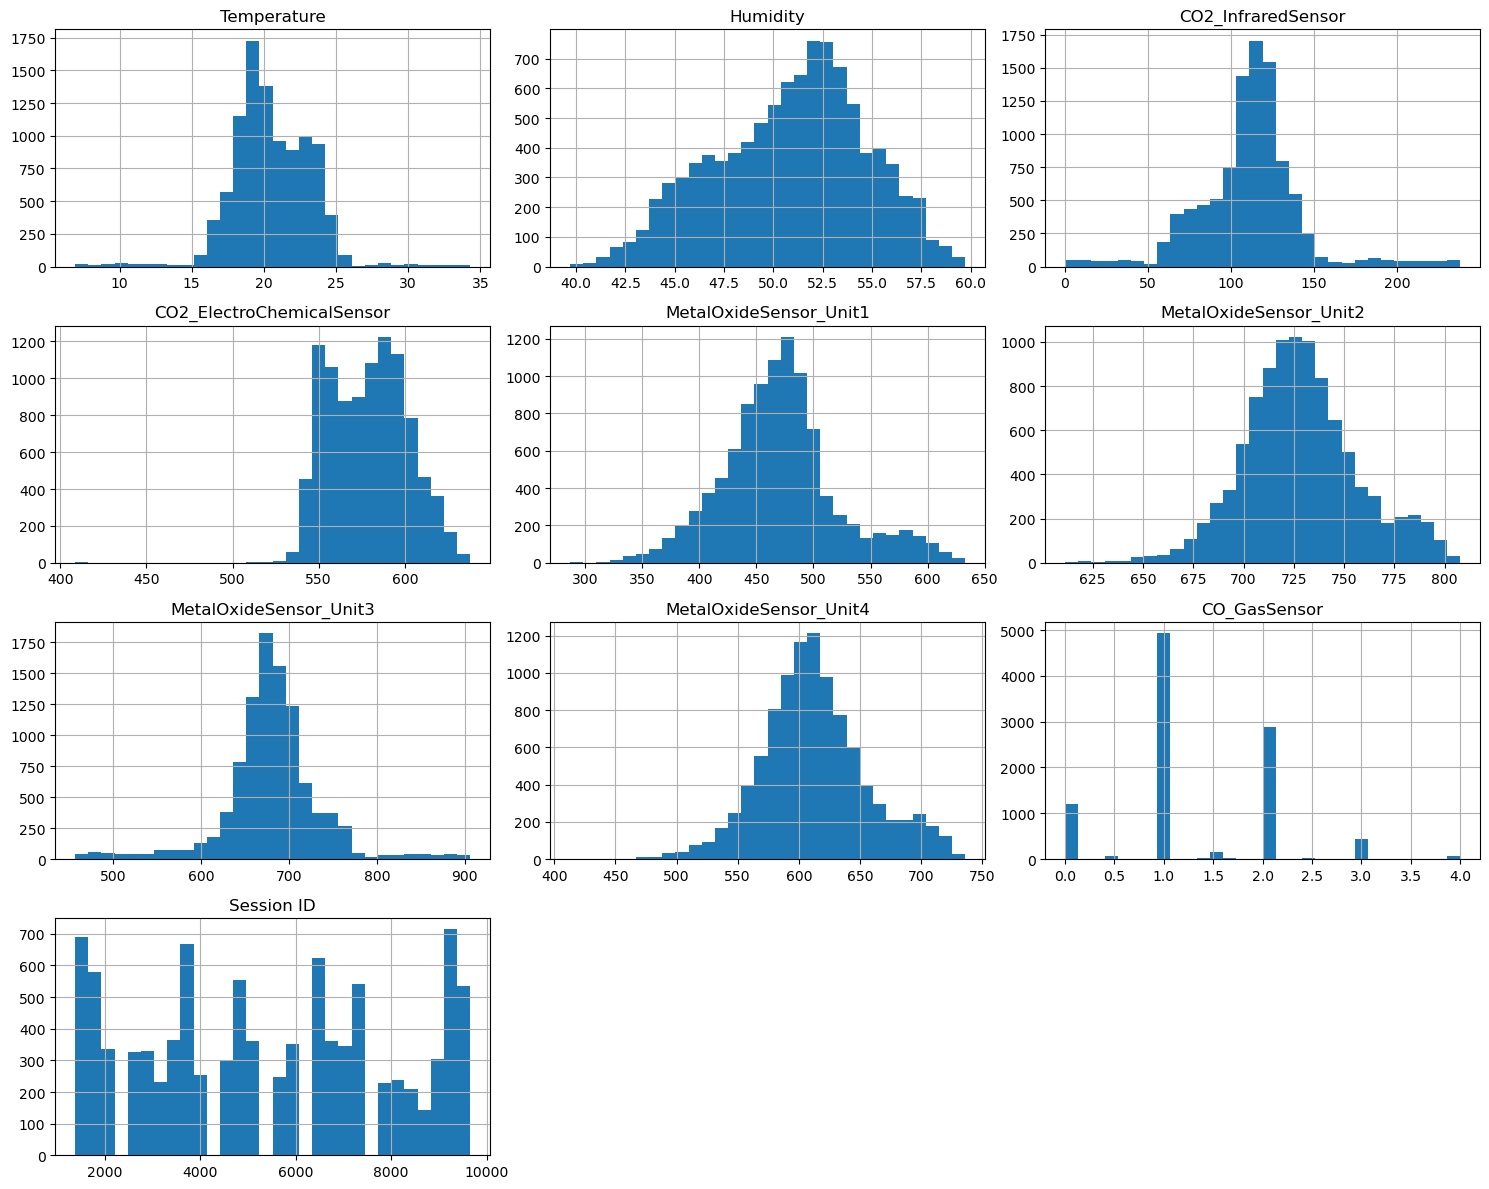

In [21]:
df.hist(figsize=(15, 12), bins=30)
plt.tight_layout()
plt.show()

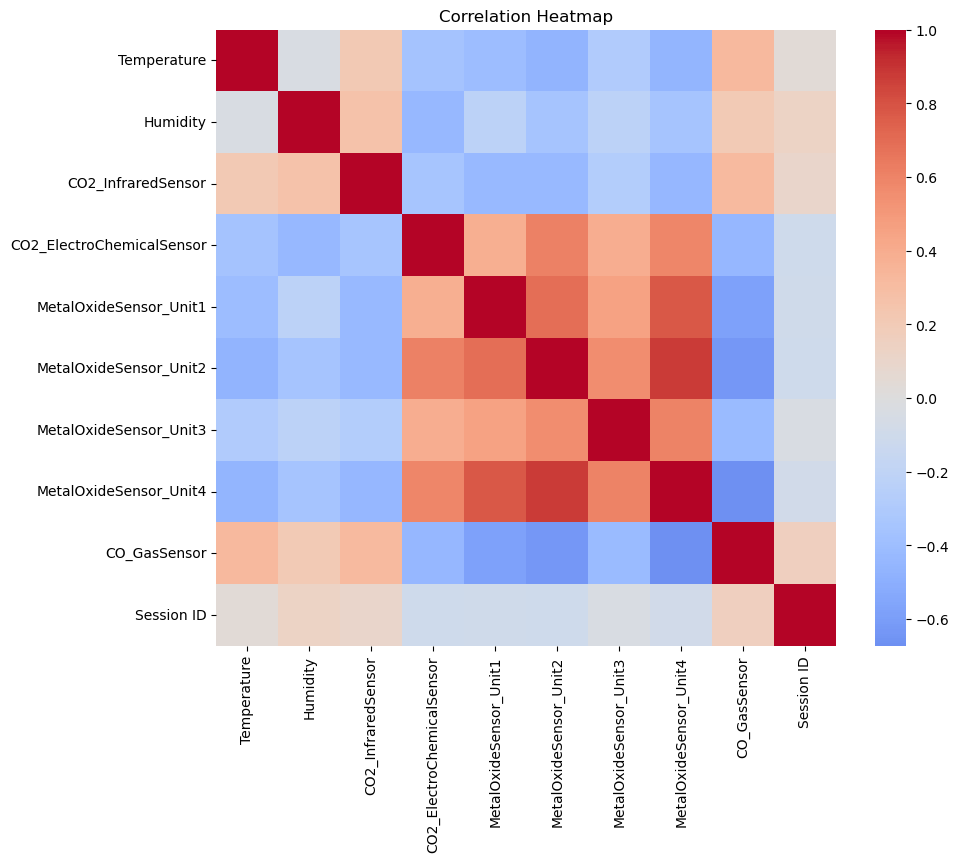

In [22]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

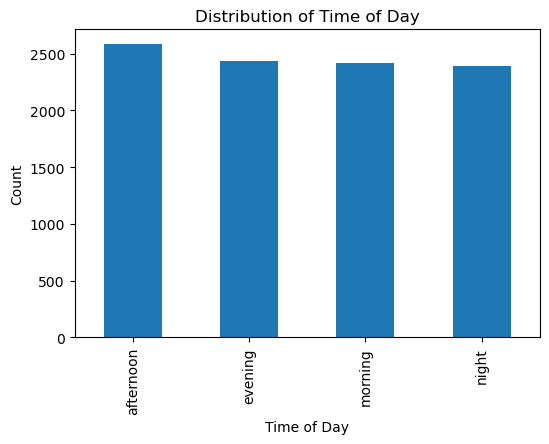

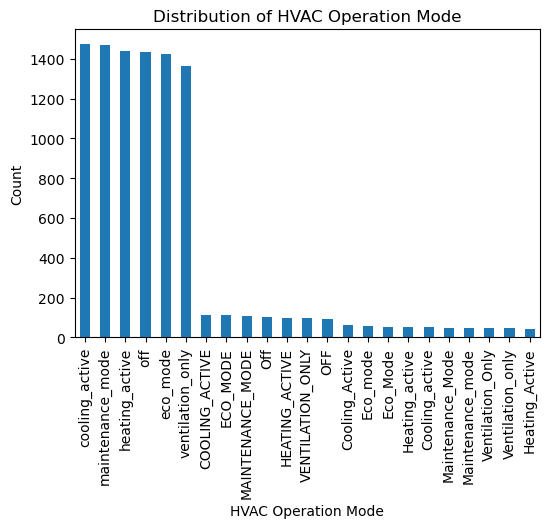

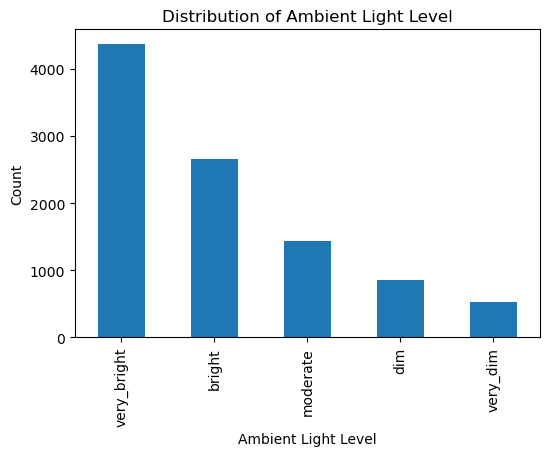

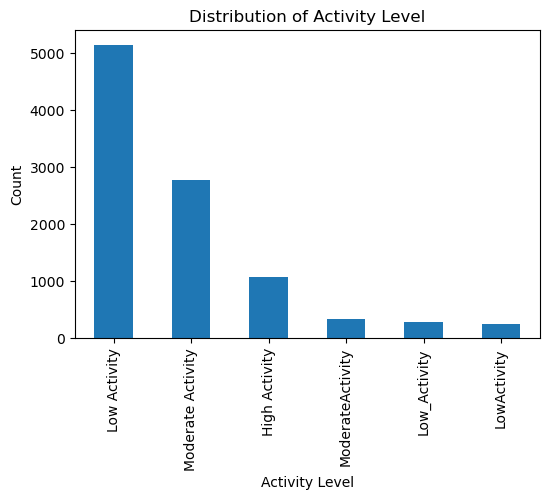

In [23]:
categorical_cols = ['Time of Day', 'HVAC Operation Mode', 'Ambient Light Level', 'Activity Level']
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.ylabel('Count')
    plt.show()

### Key Insights
- **Missing Values:** Persist mainly in `Humidity`, `MetalOxideSensor_Unit2`, `CO_GasSensor`, and `Ambient Light Level`.
- **Outliers:** Extreme values in `Temperature` and `Humidity` need careful handling.
- **Correlations:** Strong relationships between metal oxide sensors; CO2 sensors moderately correlated.
- **Target Distribution:** `Activity Level` imbalanced, dominated by 'Low Activity'.

These findings guide preprocessing (outlier handling, imputation), feature engineering, and model selection in the ML pipeline.